In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/users/aqib/desktop/ucsb/research/bccl/dmd_codes')
from monomials import Monomials
from monomials import Monomials_xu
import seaborn as sn
import pickle

In [250]:
plt.rcParams.update({'font.size':20})

#  ODEs

In [9]:
def dx_dt(x,u):
    xdot = np.zeros(len(x))
    xdot[0] = -k1f*x[0]*u[0] + k1r*x[2];
    xdot[1] = -k2f*x[1]*u[1] + k2r*x[3] -k4f*x[1]*x[4] + k4r*x[6] - k5f*x[1]*x[5] + k5r*x[7] + 0.2*x[10];
    xdot[2] = k1f*x[0]*u[0] - k1r*x[2] - k3f*x[2]*x[4] + k3r*x[5] - k6f*x[2]*x[6] + k6r*x[7];
    xdot[3] = k2f*x[1]*u[1] - k2r*x[3] - 0.2*x[3];
    xdot[4] = -k3f*x[2]*x[4] + k3r*x[5] - k4f*x[1]*x[4] + k4r*x[6];
    xdot[5] = k3f*x[2]*x[4] - k3r*x[5] - k5f*x[1]*x[5] + k5r*x[7] - k7f*x[5]*x[8] + k7r*x[9] + k8f*x[9];
    xdot[6] = -k6f*x[2]*x[6] + k6r*x[7] - k4r*x[6] + k4f*x[1]*x[4];
    xdot[7] = k5f*x[1]*x[5] - k5r*x[7] + k6f*x[2]*x[6] - k6r*x[7];
    xdot[8] = - k7f*x[5]*x[8] + (k7r+ k8f)*x[9];
    xdot[9] = k7f*x[5]*x[8] - (k7r+ k8f)*x[9];
    xdot[10] = k8f*x[9] - delta*x[10]*x[10];
    return xdot

# numerically integrate the ODEs

In [369]:
def sim_combinatorial_promoters(traj_num):
    ## SYSTEM PARAMETERS
    # Reaction Coefficients
    k1f = 1.9; # [1/min] Used kfa
    k1r = 0.25; # [1/min]
    k2f = 0.05; # [1/min] Used kfr
    k2r = 0.82; # [1/min] # Assumed that the activator and the repressor have the same type of dynamics
    k3f = 0.85
    k3r = 0.001
    k4f = 0.784
    k4r = 0.002
    k5f = 1.92
    k5r = 0.25
    k6f = 1.82
    k6r = 0.15
    k7f = 0.85
    k7r = 0.1
    k8f = 0.1
    delta = 0.02
    # Concentrations in mg/uL
    x_act = 1.5; # Activator regulator conc.
    x_rep = 0.5; # Repressor regulator conc.
    x_DNA = 2
    x_RNAP = 0.3
    conc_IND1 = 50 #mg/uL [2x conc]
    conc_IND2 = 500 #mg/uL [2x conc]

    t_START = 0
    t_END = 100
    Ts = 0.01
    numStates = 11
    states ={0:'[Act]',1:'[Rep]',2:'[Act:+Ind]',3:'[Rep:-Ind]',4:'[DNAp]',5:'[DNAp:Act:+Ind]',6:'[DNAp:Rep]',7:'[DNAp:Act:+Ind:Rep]',8:'[RNAP]',9:'[RNAP:DNAp:+Act:Ind]',10:'[mRNA]'}
    x_init = np.array([x_act,x_rep,0,0,x_DNA,0,0,0,x_RNAP,0,0])
#     x_init = np.random.uniform(0.3,1.5,11)
    Nsamp = int(np.ceil((t_END - t_START)/Ts));
    tspan = np.linspace(0,(Nsamp+1)*Ts,Nsamp+1)
    x_curr = x_init;
    x = np.array([x_curr]);
    WELL_VOL = 500;# uL
    u0 = 0; # + Inducer conc
    u1 = 0; # - Inducer conc
    IND0_var_conc =[]
    IND1_var_conc =[]
    if traj_num == 0:
        u_curr = np.array([1,0.01]) #STEP Input
    else:
        u_curr = np.random.uniform(0.01,0.9,2)
        print('u_curr: ' + str(u_curr))
    for i in range(Nsamp):
#         u_curr[0] = np.max([0,np.random.uniform(-2,1,1)])
#         u_curr[1] = np.max([0,np.random.uniform(-2,1,1)])
        WELL_VOL_NEW = WELL_VOL + u_curr[0] + u_curr[1]
        u0 = ((u0*WELL_VOL) + (conc_IND1*u_curr[0]))/WELL_VOL_NEW
#         u0 = 0
        IND0_var_conc.append(u0)
        u1 = ((u1*WELL_VOL) + (conc_IND2*u_curr[1]))/WELL_VOL_NEW
#         u1 = 10
        IND1_var_conc.append(u1)
        x_curr = x_curr + Ts*dx_dt(x_curr,np.array([u0,u1]))
        x = np.append(x,[x_curr],axis=0)
    # x = x[0:-1,:]
    # plt.plot(IND0_var_conc)
#     plt.plot(IND1_var_conc)
#     sum(x<0)

    
    input0 = np.array(IND0_var_conc).reshape(len(IND0_var_conc),1).T
    input1 = np.array(IND1_var_conc).reshape(len(IND1_var_conc),1).T
    
    input_all = np.vstack((input0,input1))
    
    return [x.T,input_all]
            
            
            

In [370]:
t_START = 0
t_END = 100
Ts = 0.01
numStates = 11
Nsamp = int(np.ceil((t_END - t_START)/Ts));
tspan = np.linspace(0,(Nsamp+1)*Ts,Nsamp+1)

numTrajectories = 20
numStates = 11
numInputs = 2
numTimepoints = len(tspan) # u is shape 10000,1 for some reason

uvec = np.empty(shape=[numInputs,numTimepoints-1,numTrajectories])
data = np.empty(shape=[numStates,numTimepoints,numTrajectories])
for traj in range(0,numTrajectories):
    x,u = sim_combinatorial_promoters(traj)
    data[:,:,traj] = x
    uvec[:,:,traj] = u

u_curr: [0.8778557  0.87565743]
u_curr: [0.17768729 0.67106911]
u_curr: [0.64616464 0.34947235]
u_curr: [0.49307597 0.27390522]
u_curr: [0.04424151 0.17014925]
u_curr: [0.17714511 0.14196375]
u_curr: [0.26535413 0.69016176]
u_curr: [0.04807276 0.69312086]
u_curr: [0.70915294 0.64632352]
u_curr: [0.10787321 0.01042721]
u_curr: [0.29995489 0.71374739]
u_curr: [0.03346861 0.21900597]
u_curr: [0.83590888 0.10401357]
u_curr: [0.09365676 0.23935145]
u_curr: [0.35793043 0.37116615]
u_curr: [0.64992229 0.12587526]
u_curr: [0.11639415 0.09543969]
u_curr: [0.2407479  0.89021147]
u_curr: [0.67554257 0.17198859]


[0.65324625 0.55512524 0.53186246 0.57111947 0.57035665 0.5331735
 0.56056423 0.53669238 0.52300754 0.55729829 0.62148111 0.53803107
 0.52790265 0.61294854 0.53720109 0.55418799 0.60100066 0.56069594
 0.53208668 0.5931208 ]


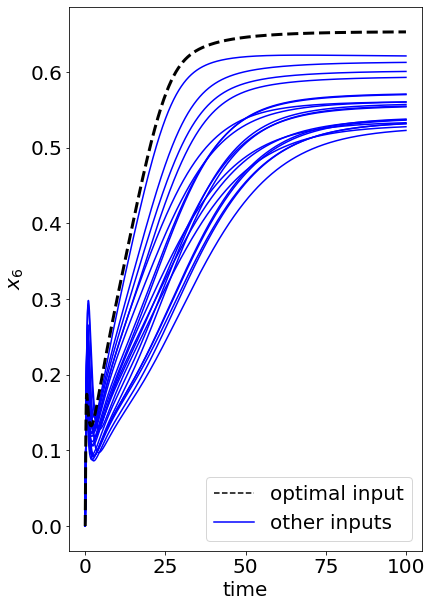

In [373]:
import matplotlib.lines as mlines

maxState = 6

print(data[maxState,-1,:])

plt.figure(figsize=(7,10));
plt.tight_layout()
plt.gcf().subplots_adjust(left=0.2)
for traj in range(1,numTrajectories):
    plt.plot(tspan,(data[maxState,:,traj]).T,color='blue')
p = plt.plot(tspan,(data[maxState,:,0]),color='black',linestyle='--',linewidth=3)
plt.xlabel('time')
plt.ylabel(r'$x_{6}$')
# plt.xlim([25,102])
# plt.ylim([0.48,1.07])
# plt.title(r'$\alpha > \beta$')
optInput = mlines.Line2D([], [], color='black',linestyle='--',label='optimal input')
otherInput = mlines.Line2D([], [], color='blue',linestyle='-',label='other inputs')
plt.legend(handles=[optInput,otherInput],loc='lower right');

import os
filename = 'combinatorial_promoters_optimal_input_x6.pdf'
path = '/users/aqib/desktop/ucsb/research/bccl/koopman_ss_prog/code/combinatorial_promoters'
fullpath = os.path.join(path, filename)
target_file = fullpath
# plt.savefig(target_file);

In [123]:
# keep_inds_x = list(np.arange(0,numTimepoints,30))
# keep_inds_u = list(np.arange(0,numTimepoints-1,30))
# data_ds = data[:,keep_inds_x,:]
# uvec_ds = uvec[:,keep_inds_u,:]

# data_ds_p = data_ds[:,:-1,:]
# data_ds_f = data_ds[:,1:,:]
# uvec_p = uvec_ds

In [124]:
# print(data_ds_p.shape)
# print(data_ds_f.shape)
# print(uvec_p.shape)

(11, 250, 80)
(11, 250, 80)
(2, 250, 80)


In [127]:
# data_x_p = data_ds_p.reshape((numStates,data_ds_p.shape[1]*numTrajectories),order='F').T
# data_x_f = data_ds_f.reshape((numStates,data_ds_f.shape[1]*numTrajectories),order='F').T
# data_u_p = uvec_p.reshape(numInputs,uvec_p.shape[1]*numTrajectories,order='F').T

# dataList = [data_x_p,data_x_f,data_u_p]

# pickle.dump(dataList,open('combinatorial_promoters.pickle','wb'))




# save data to pickle file

In [188]:
# pickle.dump( favorite_color, open( "save.p", "wb" ) )
# trpdata = pickle.load( open( "trp_input_ideal.pickle", "rb" ) )

In [194]:
# put data in rank two tensor format
# deepDMD takes the data formatted with snapshots along the rows. ???
indices_p = list(range(0,numTimepoints-1))
indices_f = list(range(1,numTimepoints))

data_x_p = data[:,indices_p].reshape((numStates,len(indices_p)*numTrajectories),order='F').T
data_x_f = data[:,indices_f].reshape((numStates,len(indices_f)*numTrajectories),order='F').T
data_u_p = uvec[:,indices_p].reshape((numInputs,len(indices_p)*numTrajectories),order='F').T

dataList = [data_x_p,data_x_f,data_u_p]

pickle.dump(dataList,open('incoherent_ff_loop.pickle','wb'))